<a href="https://colab.research.google.com/github/Ramyasri2407/Machine-learning-/blob/main/human_activity_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the required libraries.
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
'''cv2: OpenCV library for computer vision tasks.
cv2.VideoCapture(video_path): Reads the video file specified by video_path.

cv2.resize(frame, (image_width, image_height)): Resizes each frame to the desired dimensions.

cv2.cvtColor(frame, cv2.COLOR_BGR2RGB): Converts BGR (used by OpenCV) to RGB color format.'''

In [ ]:
# step 1) data download here data is
%%capture
# Download the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Install unrar if not installed (for Linux)
!apt-get install unrar -y

# Extract the Dataset
!unrar x UCF50.rar

In [ ]:
import os
print(os.listdir("/content"))

['.config', 'UCF50.rar', 'UCF50', 'sample_data']


In [ ]:
#to check whaether the dataset is downloaded
import os
print(os.listdir("/content/UCF50"))



['Punch', 'JumpingJack', 'Skijet', 'Biking', 'HulaHoop', 'Billiards', 'RockClimbingIndoor', 'JugglingBalls', 'BaseballPitch', 'Basketball', 'TaiChi', 'GolfSwing', 'HorseRace', 'PullUps', 'ThrowDiscus', 'PommelHorse', 'Diving', 'BenchPress', 'Skiing', 'PlayingGuitar', 'PoleVault', 'PlayingViolin', 'TrampolineJumping', 'BreastStroke', 'HighJump', 'WalkingWithDog', 'CleanAndJerk', 'Fencing', 'SkateBoarding', 'VolleyballSpiking', 'JavelinThrow', 'Mixing', 'Swing', 'PlayingPiano', 'Rowing', 'TennisSwing', 'PlayingTabla', 'YoYo', 'SalsaSpin', 'Kayaking', 'Nunchucks', 'MilitaryParade', 'Lunges', 'HorseRiding', 'JumpRope', 'Drumming', 'RopeClimbing', 'PizzaTossing', 'SoccerJuggling', 'PushUps']


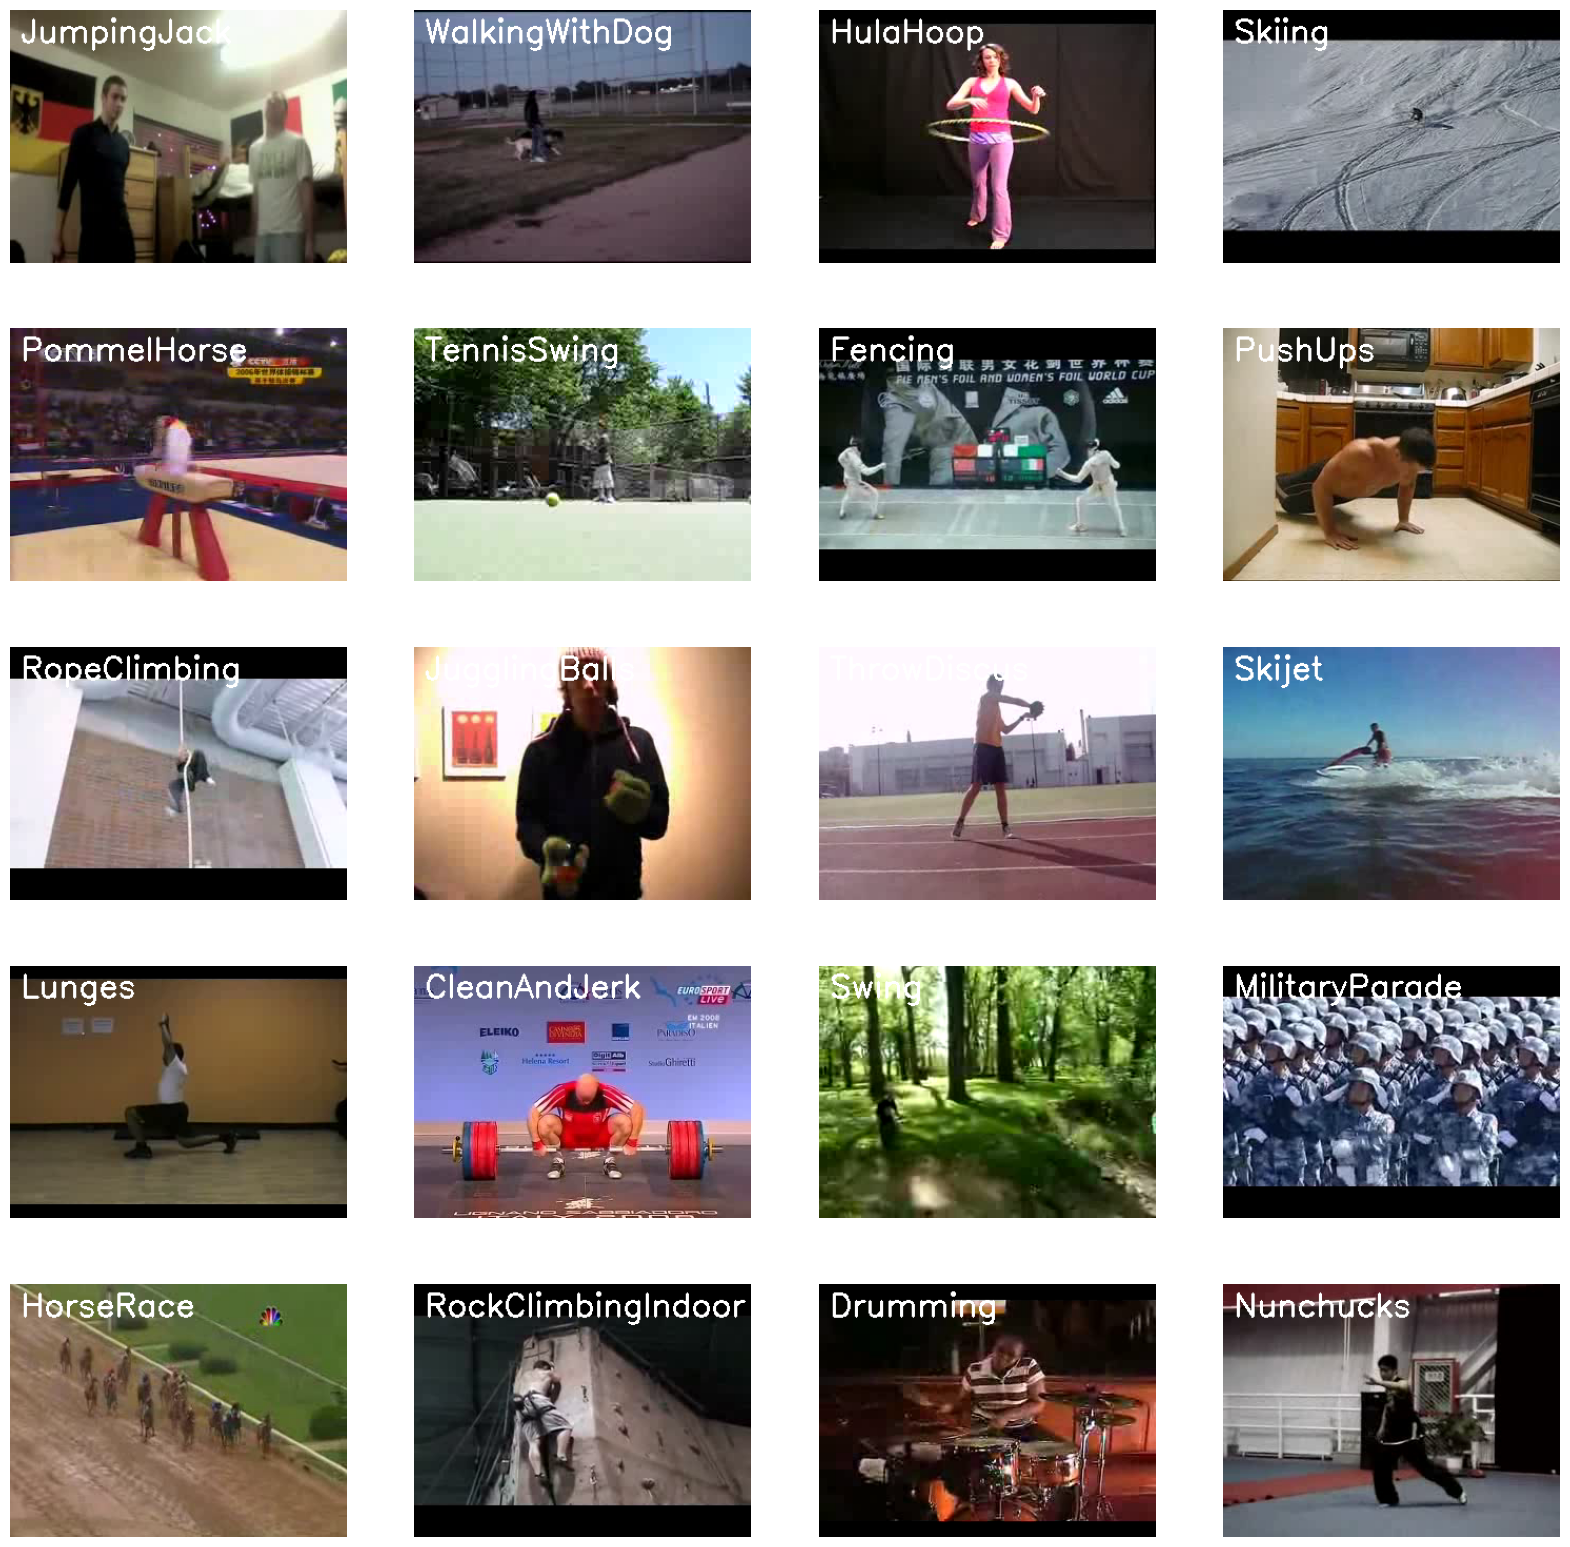

In [ ]:
# after downloading next is data visulalization
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 20))
all_classes_names = os.listdir('/content/UCF50')
#print(all_classes_names)
#random_range = random.sample(range(len(all_classes_names)), 20)
num_classes = len(all_classes_names)
sample_size =  min(20,num_classes)  # Ensure sample size does not exceed available classes
random_range = random.sample(range(num_classes), sample_size)


# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    #/content/UCF50/BaseballPitch
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')





In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "UCF50"
CLASSES_LIST = ["Basketball",  "JumpRope", "Skijet","Swing"]

In [ ]:
#video data preprocessing
def extract_frames(video_path):
   frames_list = []

    # Read the video file using the VideoCapture object
   video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
   video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list
   skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)



    # Iterate through the video frames
   for frame_counter in range(SEQUENCE_LENGTH):
        # Set the current frame position of the video
        #cv2.CAP_PROP_POS_FRAMES: the property that controls the current position of the video file in terms of frame index.

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read the frame from the video
        success, frame = video_reader.read()

        # If video frame is not successfully read, break the loop
        if not success:
            break

        # Resize the frame to the fixed height and width
        #image_width=64
        #image_height=64
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT,IMAGE_WIDTH))

        # Normalize the resized frame (scale pixel values to range [0,1])
        normalized_frame = resized_frame / 255

        # Append the normalized frame to the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object
   video_reader.release()


   return (frames_list)


In [ ]:
# creating datatset
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f"Extracting Data of Class: {class_name}")

        # Get all video files in the class directory
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract frames from the video
            frames = extract_frames(video_path)

            if len(frames)==SEQUENCE_LENGTH:
                # Append the extracted frames and class index to the respective lists
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_path)

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)



    return features, labels, video_files_paths




In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Basketball
Extracting Data of Class: JumpRope
Extracting Data of Class: Skijet
Extracting Data of Class: Swing


In [ ]:
print(features.shape)
print(labels.shape)


(522, 20, 64, 64, 3)
(522,)


In [ ]:
from tensorflow.keras.utils import to_categorical
'''labels = [0, 2, 4]
to_categorical(labels, num_classes=5)
→ [[1,0,0,0,0], [0,0,1,0,0], [0,0,0,0,1]]'''
# Convert labels to one-hot encoding
one_hot_encoded_labels = to_categorical(labels, num_classes=len(CLASSES_LIST))

In [ ]:
seed_constant = 42

# Split data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size=0.25,  random_state=seed_constant
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
from tensorflow.keras.regularizers import l2
#The model starts with 4 convolutional layers, and then lstm

def create_LRCN_model():

    model = Sequential()
    #filter size 16
    #The TimeDistributed wrapper is used to apply a layer independently to each frame in a sequence.
    #apply a penalty to the weights (also called kernels) during training.
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu',
                                     kernel_regularizer=l2(0.001)),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu',
                                     kernel_regularizer=l2(0.001))))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu',
                                     kernel_regularizer=l2(0.001))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu',
                                     kernel_regularizer=l2(0.001))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32, kernel_regularizer=l2(0.001)))
    model.add(Dense(len(CLASSES_LIST), activation='softmax', kernel_regularizer=l2(0.001)))

    model.summary()
    return model


In [ ]:
LRCN=create_LRCN_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Start training the model.
LRCN_model_training_history = LRCN.fit(
    x=features_train,
    y=labels_train,
    epochs=70,
    batch_size=4,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)


Epoch 1/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 69s 622ms/step - accuracy: 0.2817 - loss: 1.5954 - val_accuracy: 0.2785 - val_loss: 1.5123
Epoch 2/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 74s 529ms/step - accuracy: 0.2392 - loss: 1.4989 - val_accuracy: 0.3291 - val_loss: 1.4056
Epoch 3/70
 4/78 ━━━━━━━━━━━━━━━━━━━━ 35s 479ms/step - accuracy: 0.2448 - loss: 1.4589

In [ ]:
# WE ARE DOING USING CONVLSTM2D
'''ConvLSTM2D integrates convolution operations directly within the LSTM cell gates,
so it can simultaneously learn spatial and temporal features from sequences of images
 (e.g., video frames) without flattening them.''''

In [ ]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense
from keras.regularizers import l2
#1e-4=0.0001 reguralrizatin factor penality;
#The model starts with 4 convolutional layers, and then lstm
def create_convlstm_model():
    weight_decay = 1e-4  # L2 regularization strength

    model = Sequential()
#MaxPooling3D: Applies pooling over time + space.

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True,
                         kernel_regularizer=l2(weight_decay),
                         input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True,
                         kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True,
                         kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format='channels_last',
                         recurrent_dropout=0.2, return_sequences=True,
                         kernel_regularizer=l2(weight_decay)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())
    model.add(Dense(len(CLASSES_LIST), activation='softmax', kernel_regularizer=l2(weight_decay)))

    model.summary()
    return model


In [ ]:
conv_model= create_convlstm_model();
print("model is suceffuly created")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 20, 3, 3, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │        11,524 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

model is suceffuly created


In [ ]:
print(conv_model.input_shape)  # Model's expected shape
print(features_train.shape)    # Training data shape
print(labels_train.shape)
print(conv_model.output_shape)


(None, 20, 64, 64, 3)
(391, 20, 64, 64, 3)
(391, 4)
(None, 4)


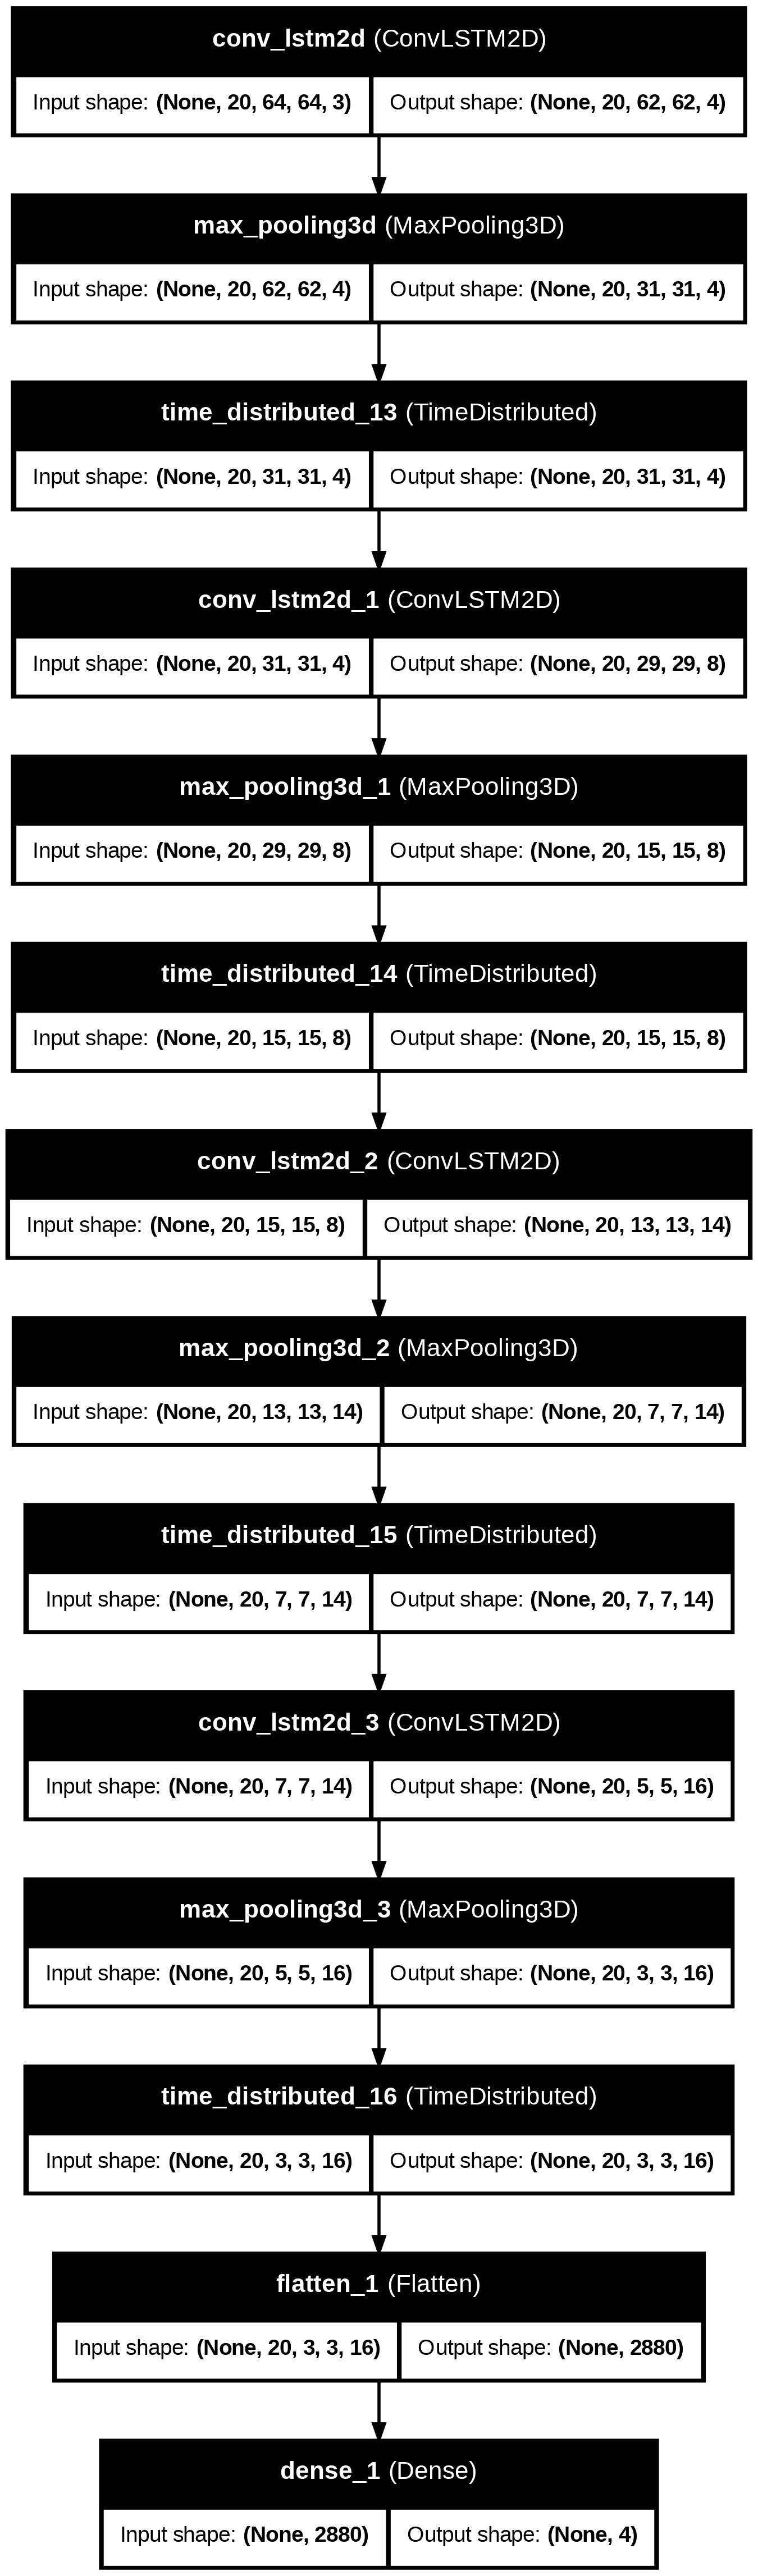

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(conv_model,to_file='comvlstm_model_structure_plot.png',show_shapes=True,show_layer_names=True)

In [ ]:
# Create EarlyStopping Callback
from tensorflow.keras.optimizers import Adam
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)

callbacks = [early_stopping_callback]

# Compile the model
optimizer = Adam()  # or use Adam()
conv_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Start training the model
conv_model_training_history = conv_model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=4,
    shuffle=True,
    validation_split=0.2,
    callbacks=callbacks
)

# Evaluate the model on test data
loss, accuracy = conv_model.evaluate(features_test, labels_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 70s 135ms/step - accuracy: 0.2473 - loss: 1.3962 - val_accuracy: 0.3291 - val_loss: 1.3554
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.4595 - loss: 1.2780 - val_accuracy: 0.4430 - val_loss: 1.2412
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5933 - loss: 1.1135 - val_accuracy: 0.6076 - val_loss: 0.8463
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6536 - loss: 0.8775 - val_accuracy: 0.7975 - val_loss: 0.5945
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6779 - loss: 0.7383 - val_accuracy: 0.7468 - val_loss: 0.6138
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7612 - loss: 0.5256 - val_accuracy: 0.7848 - val_loss: 0.5679
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8239 - loss: 0.4757 - val_accuracy: 0.7468 - val_loss: 0.7660
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9054 - loss: 0.3306 - val_accuracy: 0.7975 

In [ ]:

def predict_single_video_class(video_path, model, classes_list, sequence_length=20,
                                image_height=64, image_width=64):
    frames_list = []

    # Load video using OpenCV
    video_reader = cv2.VideoCapture(video_path)

    # Read frames until sequence length is satisfied
    while len(frames_list) < sequence_length:
        success, frame = video_reader.read()
        if not success:
            break

        # Resize and normalize
        resized_frame = cv2.resize(frame, (image_width, image_height))
        normalized_frame = resized_frame / 255.0

        frames_list.append(normalized_frame)

    video_reader.release()

    # Pad with last frame if frames are fewer than required
    if len(frames_list) < sequence_length:
        last_frame = frames_list[-1] if frames_list else np.zeros((image_height, image_width, 3))
        while len(frames_list) < sequence_length:
            frames_list.append(last_frame)

    # Convert to numpy array and reshape to model input
    input_frames = np.array(frames_list)
    #We wrap the input video in a batch, even if it's just one sample.
    input_frames = np.expand_dims(input_frames, axis=0)  # Add batch dimension

    # Predict
    predicted_label_probs = model.predict(input_frames)[0]
    predicted_label_index = np.argmax(predicted_label_probs)
    predicted_class_name = classes_list[predicted_label_index]

    return predicted_class_name


In [ ]:
video_path ="/content/UCF50/Basketball/v_Basketball_g01_c04.avi"
predicted_class = predict_single_video_class(video_path, LRCN, CLASSES_LIST)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Class: Basketball


In [ ]:
video_path ="/content/UCF50/Basketball/v_Basketball_g01_c04.avi"
predicted_class = predict_single_video_class(video_path,conv_model, CLASSES_LIST)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Basketball
